In [33]:
from process_data import clean_data, create_index, pivot_data, clean_data2
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import load_model
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [34]:
def data_lstm(X,y,lookback=1):
    newX = []
    newY = []
    for i in range(len(y)-lookback):
        newX.append(X[i:i+1+lookback,:])
        newY.append(y[i+lookback])
    return np.array(newX), np.array(newY)


def mlp(num_features):
    model = Sequential()
    model.add(Dense(12, input_dim=num_features, activation='tanh'))
    model.add(Dense(8, activation='tanh'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    return model



def train_rnn(df,date_predict,lookback,epochs=100):
    #Preparting data to Train
    #print('Preparing data to Train')
    date_p = datetime.datetime.strptime(date_predict, "%Y-%m-%d").date()
    date_limit = (date_p - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
    date_start = (date_p - datetime.timedelta(days=60+lookback//24)).strftime('%Y-%m-%d')
    sk = df[:date_limit].copy()
    print(sk.shape)
    sk = sk.drop(['TRADEDATE', 'RTENERGY'], axis=1)

    #sk.hourofday = sk.hourofday.dt.seconds/3600
    sk = sk[date_start:]
    #sk = sk[24:]
    print('Shape os SK:',sk.shape)
    y = sk.pop('DAENERGY').values
    X = sk.values[:,1:]
    #X,y = data_lstm(X,y,lookback)
    print('Shape of X',X.shape)
    #X = X[1:]
    #y = y[1:]
    print('Shape of X',X.shape)
    
    model = mlp(X.shape[1])
    #model = create_rnn(lookback,X.shape[2])

    #X = X.reshape(X.shape[0],X.shape[1],1)
    filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
    filepath="best_model_mlp.hdf5"

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    tensorboard = TensorBoard(log_dir='./logs/mlp'+str(time.time()), 
                              histogram_freq=0, 
                              batch_size=24, 
                              write_graph=True, 
                              write_grads=False, 
                              write_images=True, 
                              )
    # #Training Model
    model.fit(
        X,
        y,
        batch_size=24,  #168, 
        epochs=epochs,
        shuffle = False,
        validation_split=0.1, callbacks=[tensorboard, checkpoint, early_stop])  #0.0857 #0.05 #0.1

    #preparing data to Predict
    return model, X, y

def predict_day(date_predict,model,lookback=168):
    date_p = datetime.datetime.strptime(date_predict, "%Y-%m-%d").date()
    date_limit = (date_p - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
    date_start = (date_p - datetime.timedelta(days=42)).strftime('%Y-%m-%d')

    df_predict = df.copy()
    df_predict = df_predict[:date_predict]

    df_predict = df_predict.drop(['TRADEDATE', 'RTENERGY'], axis=1)

    #df_predict.hourofday = df_predict.hourofday.dt.seconds/3600
    df_predict = df_predict[date_start:]
    y = df_predict.pop('DAENERGY').values
    X = df_predict.values[:,1:]
    #X,y = data_lstm(X,y,lookback)

    input_p = X[-24:]   #-24
    pred = model.predict(input_p,batch_size=24)

    results = df[date_predict].copy()
    # pred_ada = model.predict(input_p.values)
    results['forecast'] = pred
    RMSE = get_rmse(results['DAENERGY'].values, pred)
    return results, RMSE

def plot_results(results,date_predict):
    RMSE = get_rmse(results['DAENERGY'], results['forecast'])
    fig, ax = plt.subplots(figsize=(9,4))
    # npre = 24
    ax.set(title='DAENERGY '+ 'RMSE: {:.3f} for {}'.format(RMSE, date_predict), xlabel='Date', ylabel='Price DAENERGY')
    #
    # # Plot data points
    results['DAENERGY'].plot(ax=ax, style='o', label='Observed')
    #
    # # Plot predictions
    results.forecast.plot(ax=ax, style='r--', label='forecast')
    # #ci = predict_ci.loc[date_predict]
    # #ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
    legend = ax.legend(loc='lower right')


def get_rmse(pred,real):
    return np.sqrt(((pred-real)**2).sum()/pred.shape[0])

def create_date_range(start_date, end_date):
    start_dt = datetime.datetime.strptime(start_date, "%Y-%m-%d").date()
    end_dt = datetime.datetime.strptime(end_date, "%Y-%m-%d").date()
    dates = []
    cur_dt = start_dt
    dates.append(start_date)
    while cur_dt<end_dt:
        cur_dt = cur_dt + datetime.timedelta(days=1)
        dates.append(cur_dt.strftime('%Y-%m-%d'))
    return dates


def create_features(df):
    df = df.copy()
    features = ['Ph-1', 'Ph-2', 'Ph-3', 'Ph-24', 'Ph-25', 'Ph-48', 'Ph-49',
                'Ph-72','Ph-73', 'Ph-96', 'Ph-97', 'Ph-120', 'Ph-121', 'Ph-144',
                'Ph-145', 'Ph-168']
    deltas = [1, 2, 3, 24, 25, 48, 49, 72, 73, 96, 97, 120, 121, 144, 145, 168]

    for col, shift in zip(features, deltas):
        df[col] = df.DAENERGY.shift(shift)
    return df

def create_rollings(df):
    df = df.copy()
    means_cols = ['mean_3','mean_6','mean_9','mean_12','mean_24']
    means_values = [3,6,9,12,24]
    
    for col, val in zip(means_cols, means_values):
        df[col] = pd.Series.rolling(df.DAENERGY, window=val, center = False).mean()
        df[col] = df[col].shift(24)
    
    #df['p_1'] = df.DAENERGY.shift(1)
    df['p_24'] = df.DAENERGY.shift(24)
    df['p_48'] = df.DAENERGY.shift(48)
    return df        

def MAPE(y_true, y_pred):
    return 1.0/len(y_true)*(np.abs((y_true-y_pred))/y_true*100).sum()



In [35]:
df = pivot_data('../data/Data.txt')
#scaler = MinMaxScaler(feature_range=(-1,1)).fit(df.DAENERGY)
#df.DAENERGY = scaler.transform(df.DAENERGY)
df = clean_data(df)
df = create_index(df)
df2 = pivot_data('../data/FurtherBack.txt','2017-05-15','2017-07-07')
df2 = clean_data2(df2)
df2 = create_index(df2)
df = pd.concat([df2,df])


df = create_rollings(df)
df = df.dropna()

wdf = pd.read_csv('../data/wstation.csv', delim_whitespace=True)
temp_cols = []
cols = df.columns.values
for col in cols:
    if len(col)==4 and col not in ['LOAD', 'p_48', 'p_72']:
        temp_cols.append(col)
        
wdf = wdf.drop_duplicates(subset = ['CALL'])

temps = pd.DataFrame(temp_cols)
temps.columns = ['CALL']
result = pd.merge(temps, wdf, how='left', on=['CALL'])
result = result[['CALL','LAT','LON']]
result = result.dropna()

from sklearn.cluster import KMeans
clusters = KMeans(n_clusters = 4).fit(result[['LAT','LON']])

result['Cluster'] = clusters.labels_

df['Temp_C_0']=df[result[result.Cluster==0]['CALL']].mean(axis=1)
df['Temp_C_1']=df[result[result.Cluster==1]['CALL']].mean(axis=1)
df['Temp_C_2']=df[result[result.Cluster==2]['CALL']].mean(axis=1)
df['Temp_C_3']=df[result[result.Cluster==3]['CALL']].mean(axis=1)

df = df.drop(temp_cols, axis=1)


list_scalers = dict()
for c in df.columns.values:
    list_scalers[c] = MinMaxScaler()
    list_scalers[c].fit(df[c].values.reshape(-1,1))
    df[c] = list_scalers[c].transform(df[c].values.reshape(-1,1))


print('Training the model...')

lookback=72#48#168

Training the model...


In [20]:
#df.DAENERGY = list_scalers['DAENERGY'].inverse_transform(df.DAENERGY.values)
start = time.time()
model, X, y = train_rnn(df,'2017-10-01',lookback=lookback,epochs=500)
print('Training time : {}'.format(time.time() - start))

(3335, 18)
('Shape os SK:', (1512, 16))
('Shape of X', (1512, 14))
('Shape of X', (1512, 14))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 12)                180       
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 293
Trainable params: 293
Non-trainable params: 0
_________________________________________________________________
Train on 1360 samples, validate on 152 samples
Epoch 1/500
1360/1360 [==============================] - 0s - loss: 0.0448 - val_loss: 0.0442
Epoch 2/500
1360/1360 [==============================] - 0s - loss: 0.0192 - val_loss: 0.0312
Epoch 3/500
1360/1360 [==============================] - 0s - loss: 0.0131 - va

1360/1360 [==============================] - 0s - loss: 0.0015 - val_loss: 0.0069
Epoch 30/500
1360/1360 [==============================] - 0s - loss: 0.0015 - val_loss: 0.0068
Epoch 31/500
1360/1360 [==============================] - 0s - loss: 0.0015 - val_loss: 0.0067
Epoch 32/500
1360/1360 [==============================] - 0s - loss: 0.0015 - val_loss: 0.0066
Epoch 33/500
1360/1360 [==============================] - 0s - loss: 0.0015 - val_loss: 0.0065
Epoch 34/500
1360/1360 [==============================] - 0s - loss: 0.0015 - val_loss: 0.0065
Epoch 35/500
1360/1360 [==============================] - 0s - loss: 0.0014 - val_loss: 0.0064
Epoch 36/500
1360/1360 [==============================] - 0s - loss: 0.0014 - val_loss: 0.0064
Epoch 37/500
1360/1360 [==============================] - 0s - loss: 0.0014 - val_loss: 0.0063
Epoch 38/500
1360/1360 [==============================] - 0s - loss: 0.0014 - val_loss: 0.0063
Epoch 39/500
1360/1360 [==============================] - 0s - 

1360/1360 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0057
Epoch 62/500
1360/1360 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0057
Epoch 63/500
1360/1360 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0056
Epoch 64/500
1360/1360 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0056
Epoch 65/500
1360/1360 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0056
Epoch 66/500
1360/1360 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0055
Epoch 67/500
1360/1360 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0055
Epoch 68/500
1360/1360 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0055
Epoch 69/500
1360/1360 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0054
Epoch 70/500
1360/1360 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0054
Epoch 71/500
1360/1360 [==============================] - 0s - 

1360/1360 [==============================] - 0s - loss: 8.3362e-04 - val_loss: 0.0045
Epoch 94/500
1360/1360 [==============================] - 0s - loss: 8.2159e-04 - val_loss: 0.0045
Epoch 95/500
1360/1360 [==============================] - 0s - loss: 8.0957e-04 - val_loss: 0.0044
Epoch 96/500
1360/1360 [==============================] - 0s - loss: 7.9757e-04 - val_loss: 0.0044
Epoch 97/500
1360/1360 [==============================] - 0s - loss: 7.8561e-04 - val_loss: 0.0044
Epoch 98/500
1360/1360 [==============================] - 0s - loss: 7.7373e-04 - val_loss: 0.0043
Epoch 99/500
1360/1360 [==============================] - 0s - loss: 7.6194e-04 - val_loss: 0.0043
Epoch 100/500
1360/1360 [==============================] - 0s - loss: 7.5027e-04 - val_loss: 0.0043
Epoch 101/500
1360/1360 [==============================] - 0s - loss: 7.3874e-04 - val_loss: 0.0042
Epoch 102/500
1360/1360 [==============================] - 0s - loss: 7.2738e-04 - val_loss: 0.0042
Epoch 103/500
1360/1

1360/1360 [==============================] - 0s - loss: 5.4063e-04 - val_loss: 0.0035
Epoch 125/500
1360/1360 [==============================] - 0s - loss: 5.3499e-04 - val_loss: 0.0035
Epoch 126/500
1360/1360 [==============================] - 0s - loss: 5.2955e-04 - val_loss: 0.0034
Epoch 127/500
1360/1360 [==============================] - 0s - loss: 5.2430e-04 - val_loss: 0.0034
Epoch 128/500
1360/1360 [==============================] - 0s - loss: 5.1923e-04 - val_loss: 0.0034
Epoch 129/500
1360/1360 [==============================] - 0s - loss: 5.1435e-04 - val_loss: 0.0034
Epoch 130/500
1360/1360 [==============================] - 0s - loss: 5.0964e-04 - val_loss: 0.0033
Epoch 131/500
1360/1360 [==============================] - 0s - loss: 5.0509e-04 - val_loss: 0.0033
Epoch 132/500
1360/1360 [==============================] - 0s - loss: 5.0071e-04 - val_loss: 0.0033
Epoch 133/500
1360/1360 [==============================] - 0s - loss: 4.9649e-04 - val_loss: 0.0032
Epoch 134/500


1360/1360 [==============================] - 0s - loss: 4.3450e-04 - val_loss: 0.0027
Epoch 156/500
1360/1360 [==============================] - 0s - loss: 4.3277e-04 - val_loss: 0.0026
Epoch 157/500
1360/1360 [==============================] - 0s - loss: 4.3110e-04 - val_loss: 0.0026
Epoch 158/500
1360/1360 [==============================] - 0s - loss: 4.2951e-04 - val_loss: 0.0026
Epoch 159/500
1360/1360 [==============================] - 0s - loss: 4.2798e-04 - val_loss: 0.0026
Epoch 160/500
1360/1360 [==============================] - 0s - loss: 4.2652e-04 - val_loss: 0.0026
Epoch 161/500
1360/1360 [==============================] - 0s - loss: 4.2511e-04 - val_loss: 0.0026
Epoch 162/500
1360/1360 [==============================] - 0s - loss: 4.2377e-04 - val_loss: 0.0025
Epoch 163/500
1360/1360 [==============================] - 0s - loss: 4.2248e-04 - val_loss: 0.0025
Epoch 164/500
1360/1360 [==============================] - 0s - loss: 4.2124e-04 - val_loss: 0.0025
Epoch 165/500


1360/1360 [==============================] - 0s - loss: 4.0399e-04 - val_loss: 0.0023
Epoch 187/500
1360/1360 [==============================] - 0s - loss: 4.0352e-04 - val_loss: 0.0023
Epoch 188/500
1360/1360 [==============================] - 0s - loss: 4.0308e-04 - val_loss: 0.0023
Epoch 189/500
1360/1360 [==============================] - 0s - loss: 4.0265e-04 - val_loss: 0.0023
Epoch 190/500
1360/1360 [==============================] - 0s - loss: 4.0223e-04 - val_loss: 0.0022
Epoch 191/500
1360/1360 [==============================] - 0s - loss: 4.0184e-04 - val_loss: 0.0022
Epoch 192/500
1360/1360 [==============================] - 0s - loss: 4.0145e-04 - val_loss: 0.0022
Epoch 193/500
1360/1360 [==============================] - 0s - loss: 4.0109e-04 - val_loss: 0.0022
Epoch 194/500
1360/1360 [==============================] - 0s - loss: 4.0074e-04 - val_loss: 0.0022
Epoch 195/500
1360/1360 [==============================] - 0s - loss: 4.0040e-04 - val_loss: 0.0022
Epoch 196/500


1360/1360 [==============================] - 0s - loss: 3.9594e-04 - val_loss: 0.0022
Epoch 218/500
1360/1360 [==============================] - 0s - loss: 3.9586e-04 - val_loss: 0.0022
Epoch 219/500
1360/1360 [==============================] - 0s - loss: 3.9579e-04 - val_loss: 0.0022
Epoch 220/500
1360/1360 [==============================] - 0s - loss: 3.9572e-04 - val_loss: 0.0022
Epoch 221/500
1360/1360 [==============================] - 0s - loss: 3.9567e-04 - val_loss: 0.0022
Epoch 222/500
1360/1360 [==============================] - 0s - loss: 3.9562e-04 - val_loss: 0.0022
Epoch 223/500
1360/1360 [==============================] - 0s - loss: 3.9559e-04 - val_loss: 0.0022
Epoch 224/500
1360/1360 [==============================] - 0s - loss: 3.9556e-04 - val_loss: 0.0022
Epoch 225/500
1360/1360 [==============================] - 0s - loss: 3.9555e-04 - val_loss: 0.0022
Epoch 226/500
1360/1360 [==============================] - 0s - loss: 3.9555e-04 - val_loss: 0.0022
Epoch 227/500


In [36]:
model = load_model('best_model_mlp.hdf5')

In [37]:
%matplotlib inline

2017-09-01
2017-09-02
2017-09-03
2017-09-04
2017-09-05
2017-09-06
2017-09-07
MAPE mean:7.64


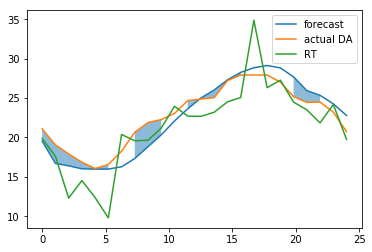

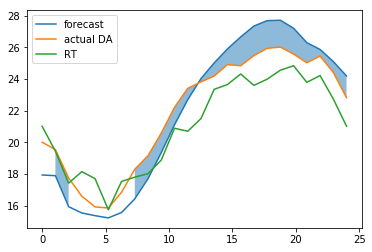

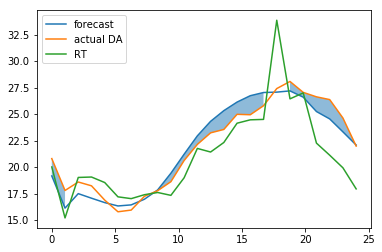

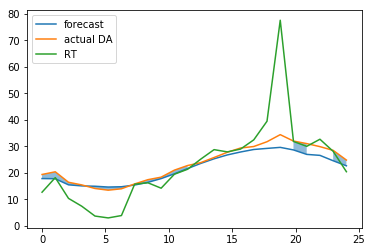

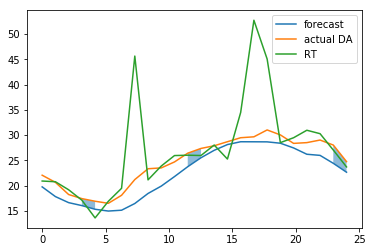

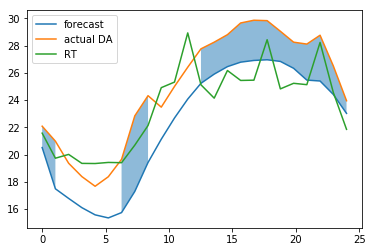

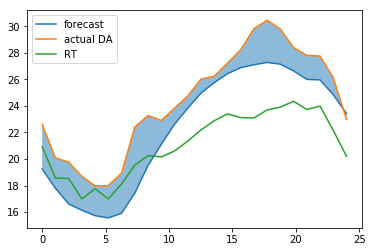

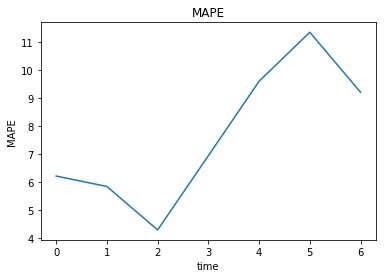

In [39]:
MAPEs = []
for day in create_date_range('2017-09-01','2017-09-07'):
    print(day)
    results, rmse = predict_day(day,model,lookback)
    plt.figure()
    #results.DAENERGY.plot()
    #results.forecast.plot()
    y_pred = list_scalers['DAENERGY'].inverse_transform(results.forecast.values.reshape(-1,1))
    y_true = list_scalers['DAENERGY'].inverse_transform(results.DAENERGY.values.reshape(-1,1))
    MAPEs.append(MAPE(y_true, y_pred))
    y_rt = list_scalers['RTENERGY'].inverse_transform(results.RTENERGY.values.reshape(-1,1))
    X  = np.linspace(0,24,24)
    plt.plot(X,y_pred, label='forecast')
    plt.plot(X,y_true, label='actual DA')
    plt.plot(X,y_rt, label='RT')
    plt.legend(loc='best')
    plt.fill_between(X,y_pred.reshape(24), y_true.reshape(24), where=y_rt.reshape(24) <= y_true.reshape(24), alpha = 0.5)


plt.figure()
plt.plot(MAPEs)
plt.title('MAPE')
plt.xlabel('time')
plt.ylabel('MAPE')
print('MAPE mean:{:.2f}'.format(np.array(MAPEs).mean()))

MAPE mean:12.60


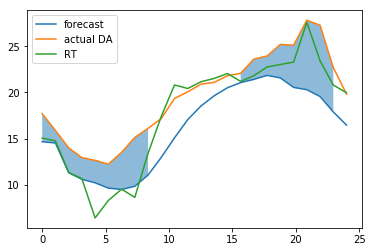

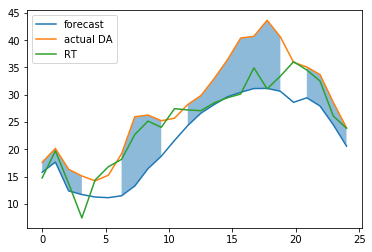

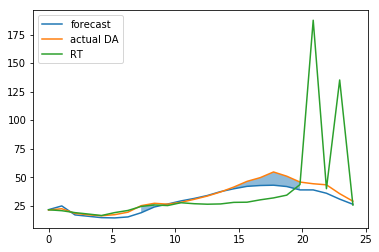

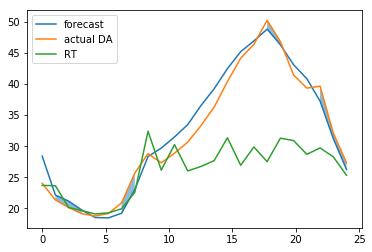

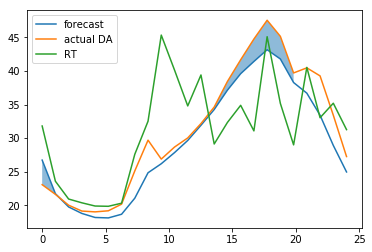

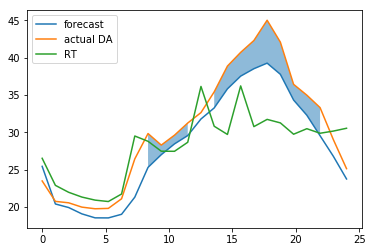

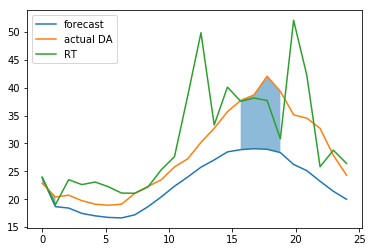

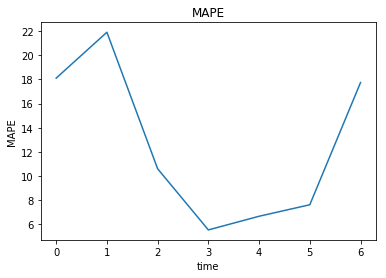

In [42]:
MAPEs=[]
for day in create_date_range('2017-10-01','2017-10-07'):
    results, rmse = predict_day(day,model,lookback)
    plt.figure()
    #results.DAENERGY.plot()
    #results.forecast.plot()
    y_pred = list_scalers['DAENERGY'].inverse_transform(results.forecast.values.reshape(-1,1))
    y_true = list_scalers['DAENERGY'].inverse_transform(results.DAENERGY.values.reshape(-1,1))
    MAPEs.append(MAPE(y_true, y_pred))
    y_rt = list_scalers['RTENERGY'].inverse_transform(results.RTENERGY.values.reshape(-1,1))
    X  = np.linspace(0,24,24)
    plt.plot(X,y_pred, label='forecast')
    plt.plot(X,y_true, label='actual DA')
    plt.plot(X,y_rt, label='RT')
    plt.legend(loc='best')
    y_true =y_true.reshape(24)
    y_pred = y_pred.reshape(24)
    y_rt = y_rt.reshape(24)
    mask = ((y_rt > y_true) & (y_pred > y_true)) | ((y_rt < y_true) & (y_pred < y_true))
    plt.fill_between(X,y_pred.reshape(24), y_true.reshape(24), where=mask, alpha = 0.5)   

plt.figure()
plt.plot(MAPEs)
plt.title('MAPE')
plt.xlabel('time')
plt.ylabel('MAPE')
print('MAPE mean:{:.2f}'.format(np.array(MAPEs).mean()))

MAPE mean:12.92


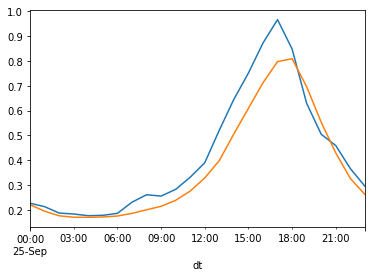

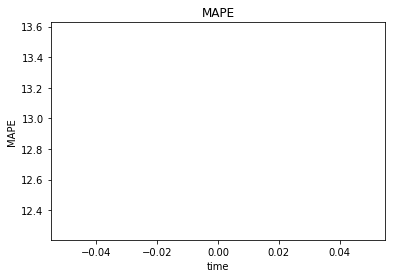

In [26]:
MAPEs=[]
day ='2017-09-25'
results, rmse = predict_day(day,model,lookback)
plt.figure()
results.DAENERGY.plot()
results.forecast.plot()
y_pred = list_scalers['DAENERGY'].inverse_transform(results.forecast.values.reshape(-1,1))
y_true = list_scalers['DAENERGY'].inverse_transform(results.DAENERGY.values.reshape(-1,1))
MAPEs.append(MAPE(y_true, y_pred))
plt.figure()
plt.plot(MAPEs)
plt.title('MAPE')
plt.xlabel('time')
plt.ylabel('MAPE')
print('MAPE mean:{:.2f}'.format(np.array(MAPEs).mean()))

In [63]:
pd.Series.rolling(df['2017-10-01'].iloc[0:3].DAENERGY, window=3, center=False).mean()

dt
2017-10-01 00:00:00         NaN
2017-10-01 01:00:00         NaN
2017-10-01 02:00:00    0.035426
Name: DAENERGY, dtype: float64

In [45]:
lookback=72
date_predict = '2017-10-01'
date_p = datetime.datetime.strptime(date_predict, "%Y-%m-%d").date()
date_limit = (date_p - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
date_start = (date_p - datetime.timedelta(days=42)).strftime('%Y-%m-%d')

df_predict = df.copy()
df_predict = df_predict[:date_predict]

df_predict = df_predict.drop(['TRADEDATE', 'RTENERGY'], axis=1)

#df_predict.hourofday = df_predict.hourofday.dt.seconds/3600
df_predict = df_predict[date_start:]
y = df_predict.pop('DAENERGY').values
X = df_predict.values[:,1:]
#X,y = data_lstm(X,y,lookback)
input_p = X[-24:]   #-24
pred = model.predict(input_p,batch_size=24)

results = df[date_predict].copy()
# pred_ada = model.predict(input_p.values)
results['forecast'] = pred
RMSE = get_rmse(results['DAENERGY'].values, pred)



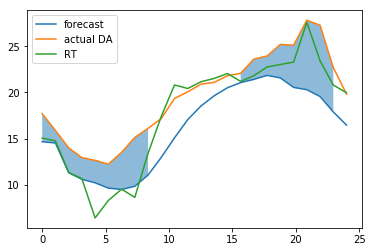

In [47]:
#results.DAENERGY.plot()
#results.forecast.plot()
y_pred = list_scalers['DAENERGY'].inverse_transform(results.forecast.values.reshape(-1,1))
y_true = list_scalers['DAENERGY'].inverse_transform(results.DAENERGY.values.reshape(-1,1))
MAPE(y_true, y_pred)
y_rt = list_scalers['RTENERGY'].inverse_transform(results.RTENERGY.values.reshape(-1,1))
X  = np.linspace(0,24,24)
plt.plot(X,y_pred, label='forecast')
plt.plot(X,y_true, label='actual DA')
plt.plot(X,y_rt, label='RT')
plt.legend(loc='best')
y_true =y_true.reshape(24)
y_pred = y_pred.reshape(24)
y_rt = y_rt.reshape(24)
mask = ((y_rt > y_true) & (y_pred > y_true)) | ((y_rt < y_true) & (y_pred < y_true))
plt.fill_between(X,y_pred.reshape(24), y_true.reshape(24), where=mask, alpha = 0.5)